# Joint project AMD + SM2L

https://docs.google.com/document/d/1oqoIyRUI_digfIokf53fox0I1eWiTFzQaae-PxMre0Y/edit

The task is to implement from scratch a learning algorithm for **regression** with **square loss** (e.g., **ridge regression**). The label to be predicted must be selected among the following 5 attributes, removing the remaining 4 from the dataset:
- PERNP (Person's earnings)
- PINCP (Person's income)
- WAGP (Wages or salary income past 12 months)
- HINCP (Household income)
- FINCP (Family income)

This code is run inside the Docker container provided in the course.

## Dataset

The project is based on the analysis of the «2013 American Community Survey» dataset published on Kaggle and released under the public domain license (CC0).

https://www.kaggle.com/census/2013-american-community-survey

The American Community Survey is an ongoing survey from the US Census Bureau. In this survey, approximately 3.5 million households per year are asked detailed questions about who they are and how they live. Many topics are covered, including ancestry, education, work, transportation, internet use, and residency.

There are two types of survey data provided, housing and population:
- For the housing data, each row is a housing unit, and the characteristics are properties like rented vs. owned, age of home, etc.
- For the population data, each row is a person and the characteristics are properties like age, gender, whether they work, method/length of commute, etc.

Each data set is divided in two pieces, "a" and "b":
- "a" contains states 1 to 25;
- "b" contains states 26 to 50.

Both data sets have weights associated with them. Weights are included to account for the fact that individuals are not sampled with equal probably (people who have a greater chance of being sampled have a lower weight to reflect this):
- Weight variable for the housing data: WGTP
- Weight variable for the population data: PWGTP

### Setup Kaggle API

In [5]:
# install kaggle API for providing the dataset
!pip install --user kaggle

Processing /home/jovyan/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b/kaggle-1.5.6-py3-none-any.whl
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
# add kaggle to PATH environment variable
import os
os.environ["PATH"] += os.pathsep + "/home/jovyan/.local/bin"

In [14]:
!mkdir ~/.kaggle
!echo '{"username":"teresatanzi","key":"a64ec0d865925975d3318adf576216b7"}' >> ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [18]:
!export KAGGLE_USERNAME=teresatanzi
!export KAGGLE_KEY=a64ec0d865925975d3318adf576216b7

In [4]:
# uncomment to uninstall kaggle
#!python -c "print('y')" | pip uninstall kaggle

Found existing installation: kaggle 1.5.6
Uninstalling kaggle-1.5.6:
  Would remove:
    /home/jovyan/.local/bin/kaggle
    /home/jovyan/.local/lib/python3.7/site-packages/kaggle-1.5.6.dist-info/*
    /home/jovyan/.local/lib/python3.7/site-packages/kaggle/*
Proceed (y/n)?   Successfully uninstalled kaggle-1.5.6


In [66]:
!pyspark --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 2.4.5
      /_/
                        
Using Scala version 2.11.12, OpenJDK 64-Bit Server VM, 1.8.0_252
Branch HEAD
Compiled by user centos on 2020-02-02T19:38:06Z
Revision cee4ecbb16917fa85f02c635925e2687400aa56b
Url https://gitbox.apache.org/repos/asf/spark.git
Type --help for more information.


### Dataset download

The dataset should not be added to the repository, but downloaded during code execution, for instance via the kaggle API 

https://github.com/Kaggle/kaggle-api

In [8]:
!mkdir ./data
!kaggle datasets download census/2013-american-community-survey -p ./data

100%|███████████████████████████████████████▉| 916M/916M [02:56<00:00, 5.74MB/s]
100%|████████████████████████████████████████| 916M/916M [02:56<00:00, 5.45MB/s]


In [9]:
import zipfile

with zipfile.ZipFile("./data/2013-american-community-survey.zip","r") as zip_ref:
    zip_ref.extractall("./data/2013-american-community-survey")

### Reading the data

The task is to implement from scratch a learning algorithm for regression with square loss (e.g., ridge regression). The label to be predicted must be selected among the following 5 attributes, removing the remaining 4 from the dataset:

- pusa dataset:
    - PERNP (Person's earnings)
    - PINCP (Person's income)
    - WAGP (Wages or salary income past 12 months)
- husa dataset:
    - HINCP (Household income)
    - FINCP (Family income)

In [1]:
import pyspark

sc = pyspark.SparkContext('local[*]')

In [2]:
import os.path

baseDir = os.path.join('./data/2013-american-community-survey')
#inputPathA = os.path.join('ss13pusa.csv')
#inputPathB = os.path.join('ss13pusb.csv')
inputPathA = os.path.join('ss13husa.csv')
inputPathB = os.path.join('ss13husb.csv')
fileNameA = os.path.join(baseDir, inputPathA)
fileNameB = os.path.join(baseDir, inputPathB)

#### Dataframe

In [3]:
from pyspark.sql import SQLContext

sqlContext = SQLContext(sc)

In [4]:
dfA = sqlContext.read.csv(fileNameA, header=True)
dfB = sqlContext.read.csv(fileNameB, header=True)

df = dfB.union(dfA)

In [5]:
n = df.count()

In [6]:
headerList = df.columns
print(len(headerList))

231


In [7]:
df.printSchema()

root
 |-- RT: string (nullable = true)
 |-- SERIALNO: string (nullable = true)
 |-- DIVISION: string (nullable = true)
 |-- PUMA: string (nullable = true)
 |-- REGION: string (nullable = true)
 |-- ST: string (nullable = true)
 |-- ADJHSG: string (nullable = true)
 |-- ADJINC: string (nullable = true)
 |-- WGTP: string (nullable = true)
 |-- NP: string (nullable = true)
 |-- TYPE: string (nullable = true)
 |-- ACCESS: string (nullable = true)
 |-- ACR: string (nullable = true)
 |-- AGS: string (nullable = true)
 |-- BATH: string (nullable = true)
 |-- BDSP: string (nullable = true)
 |-- BLD: string (nullable = true)
 |-- BROADBND: string (nullable = true)
 |-- BUS: string (nullable = true)
 |-- COMPOTHX: string (nullable = true)
 |-- CONP: string (nullable = true)
 |-- DIALUP: string (nullable = true)
 |-- DSL: string (nullable = true)
 |-- ELEP: string (nullable = true)
 |-- FIBEROP: string (nullable = true)
 |-- FS: string (nullable = true)
 |-- FULP: string (nullable = true)
 |-- GA

In [44]:
df.show(n = 1)

+---+--------+--------+-----+------+---+-------+-------+-----+---+----+------+----+----+----+----+---+--------+----+--------+----+------+----+----+-------+---+----+----+--------+---+----+------+----+-----+----+----+----+----+--------+----+----+----+-----+----+------+---------+----+----+----+---+---+----+----+----+---+----+---+----+------+------+------+-----+-----+------+-----+-----+---+---+---------+-----+-----+------+------+---+----+-----+---+---+----+---+---+---+-----+-------+---+---+---+---+---+-------+-----+----+----+----+----+----+----+-------+--------+--------+-----+-----+------+-----+-----+----------+-----+----------+-----+--------+-----+-----+---------+----+-----+-----+----------+-----+-----+-----+--------+----+-------+------+-----+------+------+----+----------+-----+------+-----+------+-----+------+--------+-----------+------+----+------+------+------+-----+-----+-----+------+------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+---

## Preprocessing

We should trasform data in objects belonging to the class LabeledPoint, but first we have to solve some issues:

- we have to deal with missing values: we can substitute those with mean or median of the corresponding column; <br>
https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4
- we have to deal with categorical values: it should be fine to just discard the feature, because only the first feature is categorical and it has a constant value for all the entry;
- we have to deal with missing values in the labels: we could discard data points with no label, because they don't really help in the training process.

In [7]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import isnan, when, count, col
import numpy as np
from pyspark.ml.feature import Imputer

def preprocess (df, na_threshold, label, imputer_strategy):
    """Preprocess a PySpark DataFrame, dealing with null values.

    Args:
        df (PySpark DataFrame): DataFrame read by the csv file.
        na_threshold (float between 0 and 1): threshold thad establish if a feature should be dropped or not
            based on its percentage of null values.
        label (string): feature that corresponds to the chosen label to be predicted.
        imputer_strategy (string): it can be `mean` or `median`, based on the imputation strategy we choose.

    Returns:
        PySpark DataFrame: Restult of the processing of the original DataFrame.
    """
    
    # remove RT: it is categorical and it has a constant value for all the data points in the dataset
    df = df.drop('RT')
    
    # remove all the features that correspond to possible labels, but are not the chosen one
    possible_labels = ['PERNP', 'PINCP', 'WAGP'] if inputPathA == 'ss13pusa.csv' else ['HINCP', 'FINCP']        
    possible_labels.remove(label)
    
    for i in possible_labels:
        df = df.drop(i)
    
    # cast features into double
    for i in df.columns:
        df = df.withColumn(i, df[i].cast(DoubleType()))
        
    # compute the dataframe containing, for each of the features, the percentange of null values
    null_df = df.select([(count(when(col(c).isNull(), c))/n).alias(c) for c in df.columns])
    
    # remove form the original dataframe all the attributes that have more null values than a given threshold
    scheme = df.columns
    null_distr = null_df.collect()[0].asDict().values()
    
    for i in np.where(np.array(list(null_distr)) > na_threshold)[0]:
        df = df.drop(scheme[i])
        
    print('We reduced the number of attributes from {} to {}.'.format(len(headerList), len(df.columns)))
    
    # remove all the data points with null value for the label
    df = df.filter(df[label].isNotNull())
    
    # replace all the missing values with the mean value of the corresponding feature
    imputer = Imputer()
    imputer.setInputCols(df.columns)
    imputer.setOutputCols(df.columns)
    imputer.setStrategy(imputer_strategy)

    df = imputer.fit(df).transform(df)

    return df
        
na_threshold = .6
label = 'HINCP'
imputer_strategy = 'mean'

df = preprocess(df, na_threshold, label, imputer_strategy)

We reduced the number of attributes from 231 to 215.


Preprocessing is almost done. We may want to:

- Remove column SERIALNO (it is just a unique number for every observation);
- Tune the threshold for the feature dropping based on the percentage of missing values.

### Labeled points

Let us now cast all the data point into `LabeledPoint`. The label is the one we select from the 5 different possible labels given by the project, while all the other possible labels have to be removed from the feature vector.

In [8]:
from pyspark.mllib.regression import LabeledPoint

def parsePoint(row):
    """Converts a row of a pyspark dataframe into a `LabeledPoint`.

    Args:
        row: Row of a dataframe composed all of double values. One of those values corresponds to the label, while
            other possible lables have to be removed.

    Returns:
        LabeledPoint: The line is converted into a `LabeledPoint`, which consists of a label and
            features.
    """
    
    # cast row into a dictionary
    row_dict = row.asDict()
    label_value = row_dict[label]
    
    del row_dict[label]
    feature_list = list(row_dict.values())
    
    return LabeledPoint(label_value, feature_list)

#parsedSamplePoints = list(map(parsePoint, df.take(5)))
#firstPointFeatures = parsedSamplePoints[0].features
#firstPointLabel = parsedSamplePoints[0].label
#print('{}, {}'.format(firstPointFeatures, firstPointLabel))

parsedData = df.rdd.map(lambda s: parsePoint(s))

parsedExamplePoint = parsedData.take(1)
examplePointFeatures = parsedExamplePoint[0].features
examplePointLabel = parsedExamplePoint[0].label
print('{}, {}'.format(examplePointFeatures, examplePointLabel))

d = len(examplePointFeatures)
print(d)

[76.0,4.0,1802.0,2.0,29.0,1000000.0,1007549.0,229.0,2.0,1.0,3.0,1.3062936394368012,1.0,2.0,7.0,1.5566063335988354,1.9844443820931135,2.0,1.9596121838007086,1.6977955999890137,80.0,1.890910489164767,2.0,2.0,3.0,1.0,3.0,910.6082502817558,1.0,1.44533933917438,1.7879980881910393,1.9832184350023345,1.0,4.0,1.0,9.0,1.932411217006784,1.0,1.0,1.0,3.0,1.0,248086.86971966035,2.0,360.0,5.0,3.123169246051848,0.0,1.0,3.134906236307153,0.31369008632643547,1.0,5.0,0.0,4.0,4.0,4.0,1.0,1.0,1.0,1.0,0.0,3.0029736555778195,0.0,1.0,0.0,24.084478191098956,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1227.739407457235,1.0,0.0,0.0,32.50750385017082,1.4557422569258112,6.382029815328111,5.843664053098351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,383.0,63.0,431.0,340.0,211.0,212.0,84.0,68.0,326.0,168.0,192.0,243.0,352.0,250.0,291.0,202.0,84.0,281.0,274.0,76.0,418.0,

In [65]:
#parsedData.take(5)

## Learning algorithm

### Training, validation and test sets

In [9]:
# lentissimo (può darsi che sia solo per i count)

weights = [.8, .1, .1]
seed = 42
parsedTrainData, parsedValData, parsedTestData = parsedData.randomSplit(weights, seed = seed)
parsedTrainData.cache()
parsedValData.cache()
parsedTestData.cache()
#nTrain = parsedTrainData.count()
#nVal = parsedValData.count()
#nTest = parsedTestData.count()

#print('{} {} {} {}'.format(nTrain, nVal, nTest, nTrain + nVal + nTest))
#print(parsedData.count())

PythonRDD[77] at RDD at PythonRDD.scala:53

In [10]:
parsedTrainData.take(1)

[LabeledPoint(37100.0, [76.0,4.0,1802.0,2.0,29.0,1000000.0,1007549.0,229.0,2.0,1.0,3.0,1.3062936394368012,1.0,2.0,7.0,1.5566063335988354,1.9844443820931135,2.0,1.9596121838007086,1.6977955999890137,80.0,1.890910489164767,2.0,2.0,3.0,1.0,3.0,910.6082502817558,1.0,1.44533933917438,1.7879980881910393,1.9832184350023345,1.0,4.0,1.0,9.0,1.932411217006784,1.0,1.0,1.0,3.0,1.0,248086.86971966035,2.0,360.0,5.0,3.123169246051848,0.0,1.0,3.134906236307153,0.31369008632643547,1.0,5.0,0.0,4.0,4.0,4.0,1.0,1.0,1.0,1.0,0.0,3.0029736555778195,0.0,1.0,0.0,24.084478191098956,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1227.739407457235,1.0,0.0,0.0,32.50750385017082,1.4557422569258112,6.382029815328111,5.843664053098351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,383.0,63.0,431.0,340.0,211.0,212.0,84.0,68.0,326.0,168.0,192.0,243.0,352.0,250.0,291.0,202.0,84.0,

In [11]:
parsedValData.take(1)

[LabeledPoint(94050.0, [695.0,4.0,2001.0,2.0,29.0,1000000.0,1007549.0,74.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,80.0,2.0,2.0,2.0,3.0,1.0,3.0,1600.0,1.0,2.0,1.0,2.0,1.0,5.0,1.0,9.0,2.0,1.0,1.0,1.0,1.0,1.0,95000.0,2.0,60.0,6.0,1.0,0.0,0.0,4.0,0.0,1.0,1.0,0.0,4.0,4.0,4.0,1.0,1.0,1.0,6.0,0.0,2.0,0.0,0.0,0.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,808.0,0.0,0.0,1.0,19.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,116.0,20.0,22.0,61.0,74.0,95.0,126.0,95.0,23.0,67.0,22.0,23.0,123.0,65.0,102.0,68.0,69.0,159.0,85.0,82.0,27.0,123.0,143.0,73.0,66.0,69.0,21.0,70.0,116.0,76.0,117.0,137.0,25.0,70.0,29.0,79.0,69.0,21.0,76.0,61.0,26.0,134.0,135.0,82.0,62.0,61.0,22.0,71.0,120.0,75.0,121.0,110.0,26.0,86.0,25.0,101.0,71.0,20.0,71.0,74.0,122.0,23.0,23.0,74.0,80.0,71.0,131.0,72.0,23.0,82.0,19.0,23.0,152.0,83.0,120.0,78.0,74.0,125

In [12]:
parsedTestData.take(1)

[LabeledPoint(41000.0, [802.0,4.0,1004.0,2.0,29.0,1000000.0,1007549.0,73.0,3.0,1.0,1.0,1.0,1.0,4.0,2.0,2.0,2.0,2.0,2.0,1.0,360.0,2.0,2.0,2.0,50.0,2.0,3.0,1300.0,1.0,2.0,1.0,2.0,1.0,10.0,1.0,9.0,2.0,1.0,1.0,1.0,1.0,1.0,300000.0,2.0,50.0,13.0,2.0,1.0,1.0,4.0,0.0,1.0,1.0,0.0,4.0,4.0,4.0,1.0,1.0,1.0,2.0,0.0,3.0,0.0,0.0,0.0,68.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,2314.0,0.0,0.0,1.0,68.0,2.0,7.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,104.0,23.0,67.0,147.0,69.0,62.0,62.0,114.0,66.0,104.0,14.0,83.0,22.0,88.0,69.0,63.0,30.0,19.0,122.0,68.0,134.0,71.0,25.0,80.0,20.0,23.0,124.0,78.0,89.0,67.0,86.0,97.0,69.0,108.0,21.0,21.0,76.0,93.0,64.0,14.0,60.0,123.0,84.0,18.0,92.0,90.0,67.0,17.0,74.0,32.0,126.0,83.0,93.0,77.0,88.0,78.0,130.0,119.0,24.0,76.0,20.0,65.0,136.0,62.0,115.0,121.0,26.0,63.0,22.0,94.0,95.0,19.0,59.0,22.0,108.0,122.0,68.0,

Maybe we should shift labels in order to make them begin from 0 (?)

In [14]:
# lento

onlyLabels = parsedData.map(lambda p: p.label)
minLbl = onlyLabels.min()
maxLbl = onlyLabels.max()
print(maxLbl, minLbl)

2090000.0 -19770.0


### Average baseline model

We predict for every data point the avarage label of the points in training set.

In [30]:
averageTrainLbl = (parsedTrainData
                    .map(lambda p: p.label)
                    .mean())

print(averageTrainLbl)

75229.84229664435


#### Square Loss

\begin{equation}
    l(\underline{w}) = \sum_{j=1}^n (\hat{y}^{(j)} - y^{(j)})^2
\end{equation}

Where:

- $\underline{w}$ is the weight vector;
- $\hat{y}^{(j)} = \underline{w} \cdot \underline{x}^{(j)}$ is our prediction with respect to the $j$-th observation;
- $y^{(j)}$ is the actual label of the $j$-th observation.

\begin{equation}
    l(\underline{w}) = \sum_{j=1}^n (\underline{w} \cdot \underline{x}^{(j)} - y^{(j)})^2
\end{equation}

In [13]:
def squaredError(label, prediction):
    """Calculates the the squared error for a single prediction.

    Args:
        label (float): The correct value for this observation.
        prediction (float): The predicted value for this observation.

    Returns:
        float: The difference between the `label` and `prediction` squared.
    """
    
    return (label - prediction) ** 2

def calcRMSE(labelsAndPreds):
    """Calculates the root mean squared error for an `RDD` of (label, prediction) tuples.

    Args:
        labelsAndPred (RDD of (float, float)): An `RDD` consisting of (label, prediction) tuples.

    Returns:
        float: The square root of the mean of the squared errors.
    """
    
    return np.sqrt(labelsAndPreds.map(lambda p: squaredError(*p)).mean())

In [31]:
labelsAndPredsTrain = parsedTrainData.map(lambda p: (p.label, averageTrainLbl))
rmseTrainBase = calcRMSE(labelsAndPredsTrain)

labelsAndPredsVal = parsedValData.map(lambda p: (p.label, averageTrainLbl))
rmseValBase = calcRMSE(labelsAndPredsVal)

labelsAndPredsTest = parsedTestData.map(lambda p: (p.label, averageTrainLbl))
rmseTestBase = calcRMSE(labelsAndPredsTest)

print('Baseline Train RMSE = {0:.3f}'.format(rmseTrainBase))
print('Baseline Validation RMSE = {0:.3f}'.format(rmseValBase))
print('Baseline Test RMSE = {0:.3f}'.format(rmseTestBase))

Baseline Train RMSE = 82202.752
Baseline Validation RMSE = 81610.228
Baseline Test RMSE = 81851.502


### Ridge regression

Learn the best weight vector $\underline{w}^{*}$:

\begin{equation}
\underline{w}^{*} = \operatorname*{argmin}_{\underline{w}} ||X \cdot \underline{w} - \underline{y}||^2 + \lambda ||\underline{w}||^2
\end{equation}

where:

- $X$ is a matrix where each row is a data point;
- $\underline{y}$ is the vector of the labels;
- $\lambda > 0$ is the regularization parameter (it has to be chosen before hands).

We can find the optimal value $\underline{w}^{*}$ computing the gradient of the function:

\begin{equation}
\underline{w}^{*} = (X^T X + \lambda I)^{-1} X^T \underline{y}
\end{equation}

#### Gradient descent

If the number $d$ of features and the number $n$ of data points in our dataset are too big, the complexity in time and space of our algorithm may be too high and we may not be able to compute the optimal value for $\underline{w}$. To solve this problem, we can rely on the gradient descent procedure:

1. choose $\underline{w}_0 \in R^d$
2. $i = 0$
3. while (!stop) {
    1. $\underline{w}_{i+1} = \underline{w}_i - \xi_i \left[ \sum_{j=1}^n (\underline{w}_i \cdot \underline{x}^{(j)} - y^{(j)}) \underline{x}^{(j)} + \lambda \underline{w}_i \right]$
    2. i++
4. }
5. return $\underline{w}_i$

Where:

- $\underline{w_i}$ is the approximated optimal weight vector;
- stop is a termination criterion of our choice;
- $\xi_i$ is the learning rate:
    \begin{equation}
        \xi_i = \frac{\xi_0}{n \sqrt{i}}
    \end{equation}

Let us focus on the update:
\begin{equation}
    \underline{w}_{i+1} = \underline{w}_i - \xi_i \left[ \sum_{j=1}^n (\underline{w}_i \cdot \underline{x}^{(j)} - y^{(j)}) \underline{x}^{(j)} + \lambda \underline{w}_i \right]
\end{equation}

Let us begin writing a function that computes the summand of the update: $(\underline{w}_i \cdot \underline{x}^{(j)} - y^{(j)}) \underline{x}^{(j)}$. 

In [14]:
from pyspark.mllib.linalg import DenseVector

def gradientSummand(weights, lp):
    """Calculates the gradient summand for a given weight and `LabeledPoint`.

    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.

    Args:
        weights (DenseVector): An array of model weights (betas).
        lp (LabeledPoint): The `LabeledPoint` for a single observation.

    Returns:
        DenseVector: An array of values the same length as `weights`.  The gradient summand.
    """
    
    return (weights.dot(DenseVector(lp.features)) - lp.label) * lp.features

Next, we write the function that makes the prediction, based on the weights vector $\underline{w}$ and the observation $\underline{x}^{(j)}$:

\begin{equation}
    \hat{y}^{(j)} = \underline{w} \cdot \underline{x}^{(j)}
\end{equation}

In [15]:
def getLabeledPrediction(weights, observation):
    """Calculates predictions and returns a (label, prediction) tuple.

    Note:
        The labels should remain unchanged as we'll use this information to calculate prediction
        error later.

    Args:
        weights (np.ndarray): An array with one weight for each features in `trainData`.
        observation (LabeledPoint): A `LabeledPoint` that contain the correct label and the
            features for the data point.

    Returns:
        tuple: A (label, prediction) tuple.
    """
    
    return (observation.label, weights.dot(DenseVector(observation.features)))

Finally, we can write the code that learns the best weight vector $\underline{w}^*$ using the gradient descent procedure.

In [61]:
import progressbar

def ridgeRegression(trainData, nIters, regFactor):
    """Calculates the weights and error for a linear regression model trained with gradient descent.

    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.

    Args:
        trainData (RDD of LabeledPoint): The labeled data for use in training the model.
        nIters (int): The number of iterations of gradient descent to perform.
        regFactor (float greater then 0): Regularization factor used in ridge regression.

    Returns:
        (np.ndarray, np.ndarray): A tuple of (weights, training errors).  Weights will be the
            final weights (one weight per feature) for the model, and training errors will contain
            an error (RMSE) for each iteration of the algorithm.
    """ 
    
    # number of data points in training set
    # TODO: count è lenta
    n = trainData.count()
    
    # number of dimensions
    d = len(trainData.take(1)[0].features)
    
    # initialize weight vector with a vector of d zero components
    w = np.zeros(d)
    
    # initialize learning rate
    csi = 1e-10
    
    # we will compute e store the training error after each iteration in order to evaluate the process
    errorTrain = np.zeros(nIters)
    
    # setup the progress bar
    bar = progressbar.ProgressBar(maxval = nIters, \
                                  widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    for i in range(nIters):
        # make the prediction with the current learnt weight vector
        labelsAndPredsTrain = trainData.map(lambda p: getLabeledPrediction(w, p))
        
        # compute the error and add it to the list
        errorTrain[i] = calcRMSE(labelsAndPredsTrain)
        
        # compute the gradient
        #gradient = sum([DenseVector(gradientSummand(w, lp)) for lp in trainData.collect()]) + (regFactor * w)
        gradientSum = trainData.map(lambda lp: DenseVector(gradientSummand(w, lp))) \
                        .reduce(lambda x, y: x + y)
        gradient = gradientSum + (regFactor * w)

        # update the learning rate
        csi_i = csi / (n * np.sqrt(i + 1))
        
        # update the weights
        w -= csi_i * gradient
        
        # update the progress bar
        bar.update(i+1)
        
    bar.finish()
    return w, errorTrain

Now, we can train our ridge regressor on the trainig data we have and evaluate it on our validation set.

In [ ]:
numIters = 10
regFactor = 0

weightsLR0, errorTrainLR0 = ridgeRegression(parsedTrainData, numIters, regFactor)

labelsAndPreds = parsedValData.map(lambda p: getLabeledPrediction(weightsLR0, p))
rmseValLR0 = calcRMSE(labelsAndPreds)

print('Validation RMSE:\n\tLR0 = {}'.format(rmseValLR0))

In [34]:
getLabeledPrediction(weightsLR0, parsedTrainData.take(1)[0])

(37100.0, 4.967139212710551e+22)

In [19]:
rmseValLR0

6.497792241156805e+22

In [23]:
rmseValLR0

6.497792241156805e+22

In [47]:
rmseValLR0

3.48827313737232e+21

In [57]:
rmseValLR0

7.505674621051639e+125

In [43]:
errorTrainLR0

array([1.11430793e+05, 2.02009388e+17, 3.94742105e+23, 6.49665179e+22,
       6.49664789e+22, 6.49664789e+22, 6.49664789e+22, 6.49664789e+22,
       6.49664789e+22, 6.49664789e+22])

In [48]:
errorTrainLR0

array([1.11430793e+05, 2.02009388e+16, 3.94740287e+21, 3.48769695e+21,
       3.48769674e+21, 3.48769674e+21, 3.48769674e+21, 3.48769674e+21,
       3.48769674e+21, 3.48769674e+21])

In [56]:
errorTrainLR0

array([1.11430793e+005, 2.02009388e+017, 3.82448847e+029, 5.91257209e+041,
       7.91608150e+053, 9.47957920e+065, 1.03628029e+078, 1.04879842e+090,
       9.92912169e+101, 8.86244153e+113])

In [63]:
errorTrainLR0

array([1.11430793e+05, 2.02009380e+12, 3.82448812e+19, 5.91257117e+26,
       7.91607969e+33, 9.47957623e+40, 1.03627987e+48, 1.04879789e+55,
       9.92911565e+61, 8.86243514e+68])

In [21]:
labelsAndPreds.take(5)

[(94050.0, 4.8820279929956165e+22),
 (56000.0, 4.8961747559783286e+22),
 (81400.0, 4.8486310474525935e+22),
 (77800.0, 4.968993843177588e+22),
 (71600.0, 4.9986627572865155e+22)]

In [49]:
labelsAndPreds.take(5)

[(94050.0, -2.636976485208402e+21),
 (56000.0, -2.6453976580037683e+21),
 (81400.0, -2.617055051018946e+21),
 (77800.0, -2.6887225223826123e+21),
 (71600.0, -2.706363563978732e+21)]

In [62]:
labelsAndPreds.take(5)

[(94050.0, -5.668182295194805e+75),
 (56000.0, -5.686014135013663e+75),
 (81400.0, -5.626011635953662e+75),
 (77800.0, -5.777761596416276e+75),
 (71600.0, -5.815122832000857e+75)]

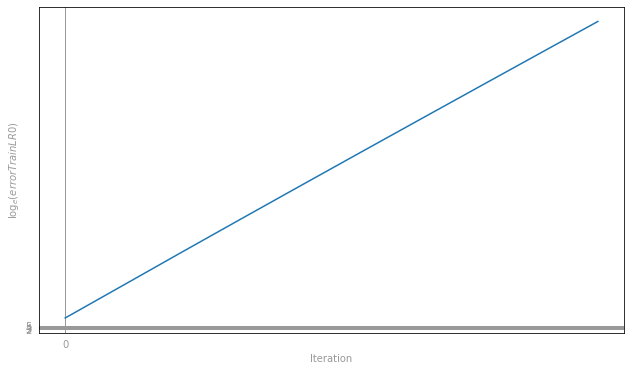

In [55]:
fig, ax = preparePlot(np.arange(0, 60, 10), np.arange(2, 6, 1))
#ax.set_ylim(2, 6)
#plt.scatter(range(0, numIters), np.log(errorTrainLR0), s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
plt.plot(range(0, numIters), np.log(errorTrainLR0))

ax.set_xlabel('Iteration'), ax.set_ylabel(r'$\log_e(errorTrainLR0)$')
plt.show()

In [25]:
weightsLR0

array([1.97122977e+16, 1.22864754e+11, 1.07848634e+14, 6.31570339e+10,
       6.67133009e+11, 2.39537684e+16, 2.41345954e+16, 2.29904132e+12,
       5.89150467e+10, 2.39537684e+10, 3.50637600e+10, 3.12854284e+10,
       2.40129561e+10, 6.76558596e+10, 7.01708596e+10, 3.73296568e+10,
       4.75355737e+10, 4.67927056e+10, 4.69390103e+10, 4.06493318e+10,
       3.20979900e+12, 4.53128059e+10, 4.49306896e+10, 3.06197360e+12,
       1.13432644e+12, 3.31241735e+10, 5.38580521e+10, 2.14420684e+13,
       2.89607681e+10, 3.46362997e+10, 4.29096398e+10, 4.75032562e+10,
       2.40266809e+10, 1.45638008e+11, 2.40279457e+10, 2.15583915e+11,
       4.62850122e+10, 2.40069368e+10, 2.40963468e+10, 2.45250323e+10,
       4.54001013e+10, 2.40145719e+10, 5.63932431e+15, 4.33738419e+10,
       9.43525848e+12, 1.21339739e+11, 7.49917363e+10, 4.85880694e+09,
       7.11376150e+09, 7.50892968e+10, 7.52160209e+09, 3.15793471e+10,
       6.45652967e+10, 9.45952599e+08, 8.15948599e+10, 8.32613161e+10,
      

In [37]:
weightsLR0

array([1.97122977e+16, 1.22864754e+11, 1.07848634e+14, 6.31570339e+10,
       6.67133009e+11, 2.39537684e+16, 2.41345954e+16, 2.29904132e+12,
       5.89150467e+10, 2.39537684e+10, 3.50637600e+10, 3.12854284e+10,
       2.40129561e+10, 6.76558596e+10, 7.01708596e+10, 3.73296568e+10,
       4.75355737e+10, 4.67927056e+10, 4.69390103e+10, 4.06493318e+10,
       3.20979900e+12, 4.53128059e+10, 4.49306896e+10, 3.06197360e+12,
       1.13432644e+12, 3.31241735e+10, 5.38580521e+10, 2.14420684e+13,
       2.89607681e+10, 3.46362997e+10, 4.29096398e+10, 4.75032562e+10,
       2.40266809e+10, 1.45638008e+11, 2.40279457e+10, 2.15583915e+11,
       4.62850122e+10, 2.40069368e+10, 2.40963468e+10, 2.45250323e+10,
       4.54001013e+10, 2.40145719e+10, 5.63932431e+15, 4.33738419e+10,
       9.43525848e+12, 1.21339739e+11, 7.49917363e+10, 4.85880694e+09,
       7.11376150e+09, 7.50892968e+10, 7.52160209e+09, 3.15793471e+10,
       6.45652967e+10, 9.45952599e+08, 8.15948599e+10, 8.32613161e+10,
      

In [27]:
print('Validation RMSE:\n\tLR0 = {}'.format(rmseValLR0))

Validation RMSE:
	LR0 = 6.497792241156805e+22


In [29]:
exampleN = 10
exampleD = 3
exampleData = (sc
               .parallelize(parsedTrainData.take(exampleN))
               .map(lambda lp: LabeledPoint(lp.label, lp.features[0:exampleD])))
print(exampleData.take(2))
exampleNumIters = 5
exampleWeights, exampleErrorTrain = ridgeRegression(exampleData, exampleNumIters, .1)
print(exampleWeights)

[LabeledPoint(37100.0, [76.0,4.0,1802.0]), LabeledPoint(76000.0, [86.0,4.0,1600.0])]


[1.30412732e+21 1.36480986e+19 6.28608326e+21]


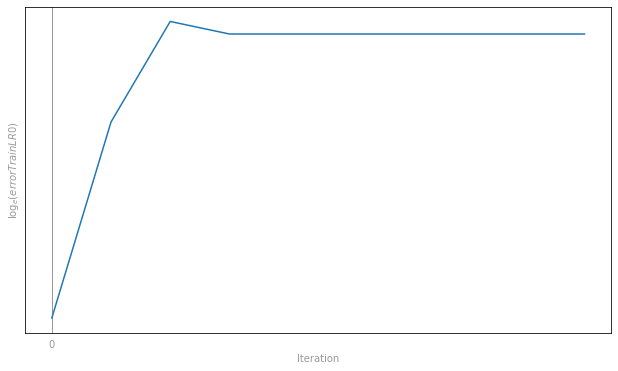

In [44]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm

def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False),
        ['bottom', 'top', 'left', 'right'])
    return fig, ax

#norm = Normalize()
#clrs = cmap(np.asarray(norm(np.log(errorTrainLR0))))[:,0:3]

fig, ax = preparePlot(np.arange(0, 60, 10), np.arange(2, 6, 1))
#ax.set_ylim(2, 6)
#plt.scatter(range(0, numIters), np.log(errorTrainLR0), s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
plt.plot(range(0, numIters), np.log(errorTrainLR0))

ax.set_xlabel('Iteration'), ax.set_ylabel(r'$\log_e(errorTrainLR0)$')
plt.show()

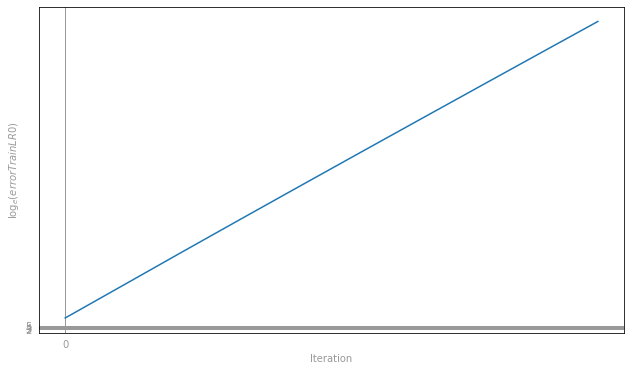

In [55]:
fig, ax = preparePlot(np.arange(0, 60, 10), np.arange(2, 6, 1))
#ax.set_ylim(2, 6)
#plt.scatter(range(0, numIters), np.log(errorTrainLR0), s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
plt.plot(range(0, numIters), np.log(errorTrainLR0))

ax.set_xlabel('Iteration'), ax.set_ylabel(r'$\log_e(errorTrainLR0)$')
plt.show()

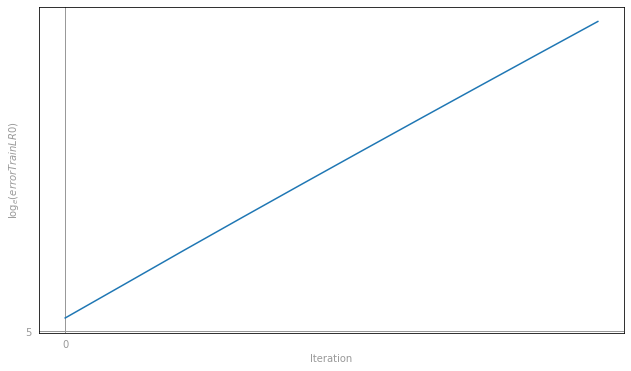

In [64]:
fig, ax = preparePlot(np.arange(0, 60, 10), np.arange(2, 6, 1))
#ax.set_ylim(2, 6)
#plt.scatter(range(0, numIters), np.log(errorTrainLR0), s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
plt.plot(range(0, numIters), np.log(errorTrainLR0))

ax.set_xlabel('Iteration'), ax.set_ylabel(r'$\log_e(errorTrainLR0)$')
plt.show()